- Run this locally by cloning the repo and replacing the dataset.

## Unzip Dataset

In [1]:
# ONLY first time run this to unzip tar file

import tarfile
import os

curr_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(curr_dir, 'data')

# Extract files from the tar file
with tarfile.open(os.path.join(data_dir, "yelp_dataset.tar"), 'r') as tar:
    tar.extractall(path=data_dir)

print(f"Files extracted to {data_dir}")

/var/folders/60/12gznrqn1nlbschqkzmlstg00000gn/T/ipykernel_75153/3574886583.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=data_dir)


Files extracted to /Users/hayato/Desktop/data_engineering/data


In [2]:
!pip install pymongo

## Import Libraries and Create Database in MongoDB

In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymongo
import os
import time


myclient = pymongo.MongoClient("mongodb://localhost")
mydb = myclient["yelp"]
business = mydb["business"]
review = mydb["review"]
user = mydb["user"]

In [4]:
# for reset
review.drop()
business.drop()
user.drop()

## ER Diagram

In [14]:
# import image module 
from IPython.display import Image
Image(url=os.path.join(data_dir, "ER_diagram.png"), width=564, height=499)

## Sampling
- The original dataset is too large to deal with in a local environment.
- Sampling 20000 objects from the business dataset and corresponding objects from other datasets in the ER diagram above.
- Embedding the sampled dataset into the database.

In [8]:
# step 1: Sample buisnesses
def sample_businesses(file_path, sample_size=20000):
    sampled_df = pd.DataFrame()
    for chunk in pd.read_json(file_path, lines=True, chunksize=50000):  # Increased chunksize
        remaining_size = sample_size - len(sampled_df)
        if remaining_size <= 0:
            break
        sampled_df = pd.concat([sampled_df, chunk.sample(n=min(remaining_size, len(chunk)), random_state=42)])
    print(f"Sampled {len(sampled_df)} businesses.")
    return sampled_df

curr_dir = os.path.dirname(os.getcwd())
business_path = os.path.join(curr_dir, 'data/yelp_academic_dataset_business.json')
sampled_business_df = sample_businesses(business_path)


Sampled 20000 businesses.


In [9]:
# step 2: Load sampled businesses into MongoDB
def load_sampled_businesses(df):
    businesses_to_insert = []
    for _, row in df.iterrows():
        business_data = {
            'business_id': row['business_id'],
            'name': row['name'],
            'address': row['address'],
            'city': row['city'],
            'state': row['state'],
            'postal_code': row['postal_code'],
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'stars': row['stars'],
            'review_count': row['review_count'],
            'is_open': bool(row['is_open']) if pd.notnull(row['is_open']) else None,
            'attributes': row['attributes'] if isinstance(row['attributes'], dict) else None,
            'categories': row['categories'],
            'hours': row['hours'] if isinstance(row['hours'], dict) else None
        }
        businesses_to_insert.append(business_data)

    if businesses_to_insert:
        business.insert_many(businesses_to_insert)
    print(f"Inserted {len(businesses_to_insert)} businesses into MongoDB.")

load_sampled_businesses(sampled_business_df)


Inserted 20000 businesses into MongoDB.


In [10]:
# step 3: Get relevant user ids
def get_relevant_user_ids(review_path, business_ids):
    user_ids = set()
    for chunk in pd.read_json(review_path, lines=True, chunksize=100000):
        filtered = chunk[chunk['business_id'].isin(business_ids)]
        user_ids.update(filtered['user_id'].unique())
    print(f"Found {len(user_ids)} relevant users.")
    return user_ids

review_path = os.path.join(curr_dir, 'data/yelp_academic_dataset_review.json')
relevant_user_ids = get_relevant_user_ids(review_path, set(sampled_business_df['business_id']))


Found 532171 relevant users.


In [11]:
# step 4: Load users into MongoDB
def load_users(file_path, relevant_user_ids):
    users_to_insert = []
    for chunk in pd.read_json(file_path, lines=True, chunksize=50000):
        filtered_chunk = chunk[chunk['user_id'].isin(relevant_user_ids)]
        for _, row in filtered_chunk.iterrows():
            try:
                user_data = {
                    'user_id': row['user_id'],
                    'name': row['name'],
                    'review_count': row['review_count'],
                    'yelping_since': row['yelping_since'],
                    'friends': row['friends'],
                    'useful': row['useful'],
                    'funny': row['funny'],
                    'cool': row['cool'],
                    'fans': row['fans'],
                    'elite': row['elite'],
                    'average_stars': row['average_stars'],
                    'compliment_hot': row['compliment_hot'],
                    'compliment_more': row['compliment_more'],
                    'compliment_profile': row['compliment_profile'],
                    'compliment_cute': row['compliment_cute'],
                    'compliment_list': row['compliment_list'],
                    'compliment_note': row['compliment_note'],
                    'compliment_plain': row['compliment_plain'],
                    'compliment_cool': row['compliment_cool'],
                    'compliment_funny': row['compliment_funny'],
                    'compliment_writer': row['compliment_writer'],
                    'compliment_photos': row['compliment_photos']
                }
                users_to_insert.append(user_data)
            except Exception as e:
                print(f"Error processing user_id {row['user_id']}: {e}")
    
    if users_to_insert:
        user.insert_many(users_to_insert)
    print(f"Inserted {len(users_to_insert)} users into MongoDB.")

user_path = os.path.join(curr_dir, 'data/yelp_academic_dataset_user.json')
load_users(user_path, relevant_user_ids)


Inserted 532169 users into MongoDB.


In [12]:
# step 5: load reviews into MongoDB
def load_reviews(file_path, business_ids, relevant_user_ids):
    reviews_to_insert = []
    for chunk in pd.read_json(file_path, lines=True, chunksize=50000):
        filtered_reviews = chunk[
            chunk['business_id'].isin(business_ids) &
            chunk['user_id'].isin(relevant_user_ids)
        ]
        
        for _, row in filtered_reviews.iterrows():
            review_data = {
                'review_id': row['review_id'],
                'user_id': row['user_id'],
                'business_id': row['business_id'],
                'stars': row['stars'],
                'useful': row['useful'],
                'funny': row['funny'],
                'cool': row['cool'],
                'text': row['text'],
                'review_date': pd.to_datetime(row['date']).replace(hour=0, minute=0, second=0, microsecond=0)
            }
            reviews_to_insert.append(review_data)

    if reviews_to_insert:
        review.insert_many(reviews_to_insert)
    print(f"Inserted {len(reviews_to_insert)} reviews into MongoDB.")

load_reviews(review_path, set(sampled_business_df['business_id']), relevant_user_ids)


Inserted 952589 reviews into MongoDB.


In [13]:
# step 6: Verify the existence of the data in MongoDB
print("Verifying row counts:")
print(f"Businesses: {business.count_documents({})}")
print(f"Users: {user.count_documents({})}")
print(f"Reviews: {review.count_documents({})}")

Verifying row counts:
Businesses: 20000
Users: 532169
Reviews: 952589


## Indexing
- Indexing is "must-do", otherwise it will take forever to run even with the sampled data.

In [15]:
user.create_index('user_id', unique=True)
review.create_index('user_id', unique=False)
review.create_index('business_id', unique=False)
business.create_index('business_id', unique=True)
print("Indexing done.")

Indexing done.


## Query 1
- Seeing how bad non-relational database performs joining operation using business and review collections.
- _Identifying top 10 cities with the highest total review counts for restaurants, with corresponding average rating._

In [16]:
query1_pipeline = [
    { "$lookup": {
      "from": "business",
      "localField": "business_id",
      "foreignField": "business_id",
      "as": "business_info"
  }},
  { "$match": { "business_info.categories": { "$regex": "Restaurant", "$options": "i" } } },
  { "$group": {
      "_id": "$business_info.city",
      "total_reviews": { "$count": {} },
      "avg_rating": { "$avg": "$stars" }
  }},
  { "$sort": { "total_reviews": -1 } },
  { "$limit": 10 }
]
def query1_stats():
  return mydb.command('explain', {'aggregate': 'review', 'pipeline': query1_pipeline, 'cursor': {}}, verbosity='executionStats')

list(review.aggregate(query1_pipeline))

[{'_id': ['Philadelphia'],
  'total_reviews': 90136,
  'avg_rating': 3.879160379870418},
 {'_id': ['New Orleans'],
  'total_reviews': 75396,
  'avg_rating': 3.958538914531275},
 {'_id': ['Nashville'],
  'total_reviews': 43187,
  'avg_rating': 3.8599810128047793},
 {'_id': ['Tampa'], 'total_reviews': 37500, 'avg_rating': 3.84096},
 {'_id': ['Indianapolis'],
  'total_reviews': 35862,
  'avg_rating': 3.8511795214990796},
 {'_id': ['Tucson'], 'total_reviews': 30443, 'avg_rating': 3.7725257037742668},
 {'_id': ['Saint Louis'],
  'total_reviews': 27667,
  'avg_rating': 3.8949289767593163},
 {'_id': ['Reno'], 'total_reviews': 21698, 'avg_rating': 3.7701170614803208},
 {'_id': ['Santa Barbara'],
  'total_reviews': 21457,
  'avg_rating': 3.9863913874260146},
 {'_id': ['Saint Petersburg'],
  'total_reviews': 11115,
  'avg_rating': 4.068196131354026}]

## Query 2
- More exploration in the business collection.
- _Identifying the top 10 highly rated restaurants that are categorized as moderately priced (i.e. attributes.RestaurantsPriceRange2 = 2), with at least 300 review counts._

In [17]:
query2_pipeline = [
    {"$match": {
        "categories": {"$regex": "Restaurant", "$options": "i"},
        "review_count": {"$gte": 300},
        "attributes.RestaurantsPriceRange2": "2"
    }},
    {"$project": {
        "name": "$name",
        "stars": "$stars",
        "address": "$address",
        "review_count": "$review_count"
    }},
    {"$group": {
        "_id": "$name",
        "stars": {"$first": "$stars"},
        "address": {"$first": "$address"},
        "review_count": {"$first": "$review_count"}
    }},
    {"$sort": {"stars": -1, "review_count": -1}},
    {"$limit": 10}
]
def query2_stats():
    return mydb.command('explain', {'aggregate': 'business', 'pipeline': query2_pipeline, 'cursor': {}}, verbosity='executionStats')

list(business.aggregate(query2_pipeline))

[{'_id': 'Kaffe Crepe',
  'stars': 5.0,
  'address': '1300 East Plumb Ln, Ste C4',
  'review_count': 454},
 {'_id': 'German Bistro 2',
  'stars': 5.0,
  'address': '1300 East Bay Dr',
  'review_count': 301},
 {'_id': 'Peg Leg Porker',
  'stars': 4.5,
  'address': '903 Gleaves St',
  'review_count': 2878},
 {'_id': "Jacques-Imo's Cafe",
  'stars': 4.5,
  'address': '8324 Oak St',
  'review_count': 2406},
 {'_id': 'The Eagle',
  'stars': 4.5,
  'address': '310 Massachusetts Ave',
  'review_count': 2233},
 {'_id': 'Bodega',
  'stars': 4.5,
  'address': '1180 Central Ave',
  'review_count': 1772},
 {'_id': 'Sugarfire Smoke House',
  'stars': 4.5,
  'address': '9200 Olive Blvd',
  'review_count': 1627},
 {'_id': "John's Roast Pork",
  'stars': 4.5,
  'address': '14 E Snyder Ave',
  'review_count': 1564},
 {'_id': "Mazzaro's Italian Market",
  'stars': 4.5,
  'address': '2909 22nd Ave N',
  'review_count': 1551},
 {'_id': 'Rusty Bellies',
  'stars': 4.5,
  'address': '937 Dodecanese Blvd',
 

## Query 3
- Get familier with window functions in MongoDB.
- Surprisingly, MongoDB supports window functions. However, it does NOT support multiple attributes in the "sortBy" parameter unlike most SQL databases.
- _Identifying the top 3 businesses (not just restaurants) by rating for each city (city rank) and their overall ranks. Sorting the result by city name, breaking ties by city rank._
- SQL databases such as PostgreSQL can perform better in this particular type of queries since it allows multiple sorting attributes in window functions.

In [18]:
query3_pipeline = [
  {
    "$setWindowFields": {
      "partitionBy": "$city",
      "sortBy": { "stars": -1 },
      "output": { "city_rank": { "$rank": {} } }
    } 
  },
  {
    "$setWindowFields": {
      "sortBy": { "stars": -1 },
      "output": { "overall_rank": { "$rank": {} } }
    }
  },
  {
    "$match": { "city_rank": { "$lte": 3 } }
  },
  {
    "$sort": { "city": 1, "city_rank": 1}
  },
  {
    "$project": {"_id": 0, "name": 1, "city": 1, "stars": 1, "review_count": 1, "city_rank": "$city_rank", "overall_rank": "$overall_rank"}
  },
  {
    "$limit": 10
  }
]
def query3_stats():
  return mydb.command('explain', {'aggregate': 'business', 'pipeline': query3_pipeline, 'cursor': {}}, verbosity='executionStats')

list(business.aggregate(query3_pipeline))

[{'name': 'Emoji Sushi & Teriyaki',
  'city': 'Abington',
  'stars': 5.0,
  'review_count': 13,
  'city_rank': 1,
  'overall_rank': 1},
 {'name': 'Gus Arias Painting',
  'city': 'Abington',
  'stars': 4.5,
  'review_count': 6,
  'city_rank': 2,
  'overall_rank': 2220},
 {'name': 'Briar Bush Nature Center',
  'city': 'Abington',
  'stars': 4.5,
  'review_count': 7,
  'city_rank': 2,
  'overall_rank': 2220},
 {'name': 'South Sea Thai Kitchen',
  'city': 'Abington',
  'stars': 4.5,
  'review_count': 33,
  'city_rank': 2,
  'overall_rank': 2220},
 {'name': "Juan's Reflexology",
  'city': 'Abington',
  'stars': 4.5,
  'review_count': 16,
  'city_rank': 2,
  'overall_rank': 2220},
 {'name': 'Easy Living Home Care',
  'city': 'Abington',
  'stars': 4.5,
  'review_count': 6,
  'city_rank': 2,
  'overall_rank': 2220},
 {'name': 'Big Top Beverage',
  'city': 'Abington',
  'stars': 4.5,
  'review_count': 14,
  'city_rank': 2,
  'overall_rank': 2220},
 {'name': 'TerraVida Holistic Centers',
  'cit

## Query 4
- See how bad the non-relational database performs joining using business and review collections, part 2.
- _Identifying the ranking of days in a week by review counts of only businesses that have at least 500 reviews._

In [22]:
query4_pipeline = [
    { "$lookup": {
        "from": "business",
        "localField": "business_id",
        "foreignField": "business_id",
        "as": "business_info"
    }},
    { "$match": { "business_info.review_count": { "$gt": 500 } } },
    { "$addFields": {"group_id": {"$dayOfWeek": {"date": "$review_date"}}} },
    { "$group": {
        "_id": "$group_id",
        "total_reviews": { "$count": {} }
    }},
    { "$sort": { "total_reviews": -1 } }
]
def query4_stats():
    return mydb.command('explain', {'aggregate': 'review', 'pipeline': query4_pipeline, 'cursor': {}}, verbosity='executionStats')

list(review.aggregate(query4_pipeline))

[{'_id': 1, 'total_reviews': 31519},
 {'_id': 2, 'total_reviews': 28718},
 {'_id': 7, 'total_reviews': 27299},
 {'_id': 3, 'total_reviews': 25661},
 {'_id': 4, 'total_reviews': 24945},
 {'_id': 6, 'total_reviews': 23776},
 {'_id': 5, 'total_reviews': 23508}]

## Query 5
- The worst case scenario for non-relational databases: need to join all collections.
- _Identifying users in Philadelphia who have written more than 500 reviews, their average rating, and their elite status information._

In [20]:
query5_pipeline = [
    { "$match": { "review_count": { "$gt": 500 } } },
    { "$lookup": {
        "from": "review",
        "localField": "user_id",
        "foreignField": "user_id",
        "pipeline": [ { "$project": { "business_id": 1, "_id": 0 } } ],
        "as": "review_info"
    }},
    { "$unwind": {"path": "$review_info", "preserveNullAndEmptyArrays": False } },
    { "$lookup": {
        "from": "business",
        "localField": "review_info.business_id",
        "foreignField": "business_id",
        "as": "business_info"
    }},
    { "$match": {"business_info.city": "Philadelphia"}},
    { "$group": { "_id": "$user_id", "name": {"$first": "$name"}, "review_count": {"$first": "$review_count"}, "average_stars": {"$first": "$average_stars"}, "elite": {"$first": "$elite"}}},
    { "$project": { "_id": 0, "name": 1, "review_count": 1, "average_stars": 1, "elite": 1}},
    { "$sort": {"average_stars": -1}},
    { "$limit": 10}
]
def query5_stats():
    return mydb.command('explain', {'aggregate': 'user', 'pipeline': query5_pipeline, 'cursor': {}}, verbosity='executionStats')

list(user.aggregate(query5_pipeline))

[{'name': 'Lori',
  'review_count': 666,
  'average_stars': 4.91,
  'elite': '2012,2013,2014,2015,2016,2017,2018,2019,20,20,2021'},
 {'name': 'Dewan', 'review_count': 1600, 'average_stars': 4.85, 'elite': ''},
 {'name': 'Belle',
  'review_count': 569,
  'average_stars': 4.75,
  'elite': '2017,2018,2019,20,20,2021'},
 {'name': 'Crystal',
  'review_count': 937,
  'average_stars': 4.64,
  'elite': '2012,2013,2014,2015,2016,2017,2018,2019,20,20,2021'},
 {'name': 'Matt', 'review_count': 3193, 'average_stars': 4.64, 'elite': ''},
 {'name': 'Khoi',
  'review_count': 785,
  'average_stars': 4.63,
  'elite': '2016,2017,2018,2019,20,20,2021'},
 {'name': 'James',
  'review_count': 920,
  'average_stars': 4.61,
  'elite': '20,20,2021'},
 {'name': 'Carlo', 'review_count': 630, 'average_stars': 4.59, 'elite': ''},
 {'name': 'Chelsea',
  'review_count': 748,
  'average_stars': 4.58,
  'elite': '2012,2013,2014,2015,2016,2017,2018,2019,20,20,2021'},
 {'name': 'Ada',
  'review_count': 621,
  'average_st

## Visualization
- Measure the average execution time and the average document & keys scanned (should be stable) by running each query 10 times.


=== Running Query 1 ===

🔄 Run 1/10...
⏱ Execution Time: 6454.00 ms
💰 Total Documents & Keys Examined: 2857767.00

🔄 Run 2/10...
⏱ Execution Time: 5978.00 ms
💰 Total Documents & Keys Examined: 2857767.00

🔄 Run 3/10...
⏱ Execution Time: 5965.00 ms
💰 Total Documents & Keys Examined: 2857767.00

🔄 Run 4/10...
⏱ Execution Time: 6016.00 ms
💰 Total Documents & Keys Examined: 2857767.00

🔄 Run 5/10...
⏱ Execution Time: 6160.00 ms
💰 Total Documents & Keys Examined: 2857767.00

🔄 Run 6/10...
⏱ Execution Time: 6080.00 ms
💰 Total Documents & Keys Examined: 2857767.00

🔄 Run 7/10...
⏱ Execution Time: 6073.00 ms
💰 Total Documents & Keys Examined: 2857767.00

🔄 Run 8/10...
⏱ Execution Time: 6095.00 ms
💰 Total Documents & Keys Examined: 2857767.00

🔄 Run 9/10...
⏱ Execution Time: 6098.00 ms
💰 Total Documents & Keys Examined: 2857767.00

🔄 Run 10/10...
⏱ Execution Time: 6230.00 ms
💰 Total Documents & Keys Examined: 2857767.00

✅ Query 1 Completed.

EXPLAIN COMMAND OUTPUT (AVERAGE):
 Execution Time: 

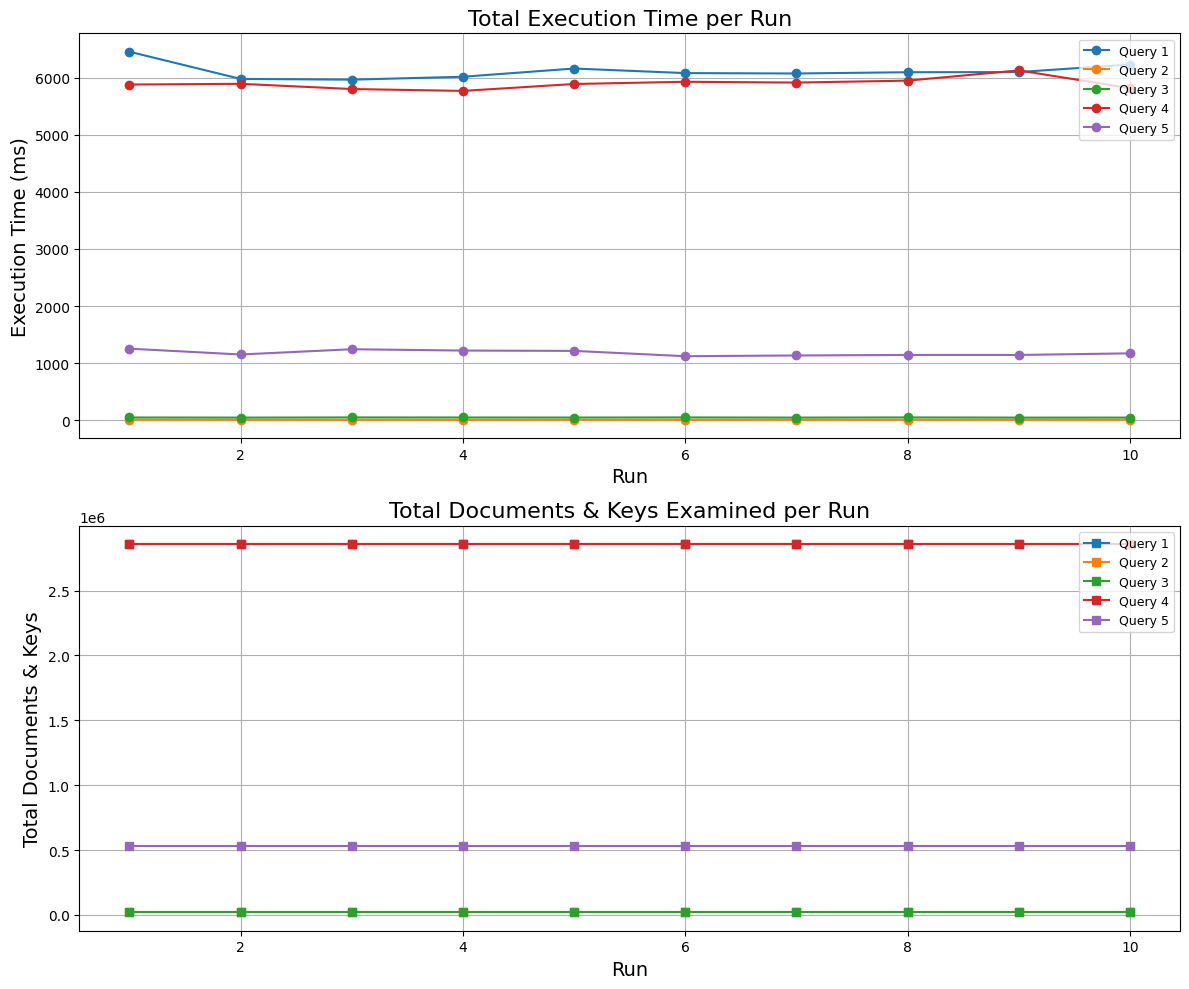

<Figure size 640x480 with 0 Axes>

CPU times: user 631 ms, sys: 57.1 ms, total: 688 ms
Wall time: 2min 12s


In [21]:
%%time
# Function to print formatted EXPLAIN ANALYZE results
def print_explain_analyze_results(avg_latency, avg_memory):
    print("\nEXPLAIN COMMAND OUTPUT (AVERAGE):")
    print(f" Execution Time: {avg_latency:.2f} ms")
    if avg_memory is not None:
        print(f"Documents & Keys Examined: {avg_memory:.2f} counts")

# Function to run a query multiple times and collect performance data
def execute_and_time_query(stats_func, query_name, runs=10):
    latencies = []
    total_costs = []
    print(f"\n=== Running {query_name} ===\n")
    for i in range(runs):
        print(f"🔄 Run {i+1}/{runs}...")
        stats = stats_func()

        latency = stats['stages'][0]['$cursor']['executionStats']['executionTimeMillis']  # Execution time in ms
        cost = stats['stages'][0]['$cursor']['executionStats']['totalKeysExamined'] + stats['stages'][0]['$cursor']['executionStats']['totalDocsExamined']  # Total query cost (est)
        latencies.append(latency)
        total_costs.append(cost)

        print(f"⏱ Execution Time: {latency:.2f} ms")
        print(f"💰 Total Documents & Keys Examined: {cost:.2f}\n")

    avg_latency = sum(latencies) / len(latencies)
    avg_cost = sum(total_costs) / len(total_costs)

    print(f"✅ {query_name} Completed.")
    print_explain_analyze_results(avg_latency, avg_cost)

    return latencies, total_costs

results = {}
runs = 10  # Number of times to run each query
queries = {"Query 1": query1_stats, "Query 2": query2_stats, "Query 3": query3_stats, "Query 4": query4_stats, "Query 5": query5_stats}
for query_name, stats_func in queries.items():
    latencies, total_costs = execute_and_time_query(stats_func, query_name, runs=runs)
    results[query_name] = {
    "latencies": latencies,
    "total_costs": total_costs
    }


# Plot the execution times and memory usage for each query
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Execution Time Plot
for query_name, data in results.items():
    axs[0].plot(range(1, runs + 1), data["latencies"], marker="o", label=query_name)
axs[0].set_title("Total Execution Time per Run", fontsize=16)
axs[0].set_xlabel("Run", fontsize=14)
axs[0].set_ylabel("Execution Time (ms)", fontsize=14)
axs[0].legend(fontsize=9, loc="upper right")
axs[0].grid(True)

# Total Cost Plot
for query_name, data in results.items():
    axs[1].plot(range(1, runs + 1), data["total_costs"], marker="s", label=query_name)
axs[1].set_title("Total Documents & Keys Examined per Run", fontsize=16)
axs[1].set_xlabel("Run", fontsize=14)
axs[1].set_ylabel("Total Documents & Keys", fontsize=14)
axs[1].legend(fontsize=9, loc="upper right")
axs[1].grid(True)

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


- Note query 1 and 4, query 2 and 3 have the same total documents & keys scanned respectively.

## Summary
- Comparing query 5 to query 1 and 4, query 5 resulted less time and cost even it joins 3 collections together. This is mainly because predicate push down (filtering first before joining) works well in it. 
- Yet, we can still confirm that non-relational databases are bad at joining operations compared to SQL performances. MongoDB's primary language is JSON, whose data includes a lot of redundancy because of its nested data nature. Therefore, it is apparant that MongoDB is bad at operations that require to join collections.
- When to use non-relational databases: the data is large, and the query or our task is just to filter out documents and output limited (like 10) results within the same collection.
- One good thing for JSON is that it is very light - it can store a lot of data in few pages. MongoDB's native language is JSON, which means it is more smooth and making-sense to use it for query operations for JSON data.